# Review Sentiment Analysis – XGBoost

Gradient boosted trees with targeted EDA for Beyond Flavours restaurant reviews.

In [20]:
from __future__ import annotations

from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

sns.set_theme(context="talk", style="whitegrid")


In [21]:
DATA_PATH = Path("..") / "data" / "raw" / "restaurant_reviews.csv"
df = pd.read_csv(DATA_PATH)
df.head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


## Preprocess labels and engineer helper features

Mirror the shared sentiment buckets and enrich with text-length signals for comparability across notebooks.


In [22]:
def map_rating_to_label(rating: float) -> Literal["good", "bad"]:
    """Return the coarse sentiment bucket for a numeric rating.


    Ratings of 4.0 and above are marked 'very good', between 3.0 and 4.0 are

    treated as 'bad' (lukewarm), and anything below 3.0 is considered

    'horrible' per the project specification.

    """

    if rating > 3.0:
        return "good"
    return "bad"


df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df["Review"] = df["Review"].fillna("").str.strip()
df = df.dropna(subset=["Rating"])
df = df[df["Review"] != ""].copy()
df["sentiment"] = df["Rating"].apply(map_rating_to_label)
df["review_length"] = df["Review"].str.len()
df["word_count"] = df["Review"].str.split().str.len()
df[["Rating", "sentiment", "review_length", "word_count"]].head()


,Rating,sentiment,review_length,word_count
0,5.0,good,222,41
1,5.0,good,144,27
2,5.0,good,189,31
3,5.0,good,148,28
4,5.0,good,160,27


## Train XGBoost classifier

Use TF-IDF features with class balancing through scale_pos_weight-style ratios via sample weighting.


In [25]:
label_counts = df["sentiment"].value_counts()

stratify_labels = df["sentiment"] if label_counts.min() > 1 else None

X_train, X_test, y_train, y_test = train_test_split(

    df["Review"],

    df["sentiment"],

    test_size=0.2,

    random_state=42,

    stratify=stratify_labels,

)



vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=1000)

X_train_tfidf = vectorizer.fit_transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)



label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)

y_test_enc = label_encoder.transform(y_test)



class_frequency = label_counts.loc[label_encoder.classes_]

balanced_weights = class_frequency.sum() / (class_frequency * len(class_frequency))

sample_weights = balanced_weights.values[y_train_enc]



xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    learning_rate=0.2,
    max_depth=6,
    n_estimators=400,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    reg_lambda=1.0,
    random_state=42,
    tree_method="auto",
)
xgb_model.fit(X_train_tfidf, y_train_enc, sample_weight=sample_weights)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [26]:
y_pred_enc = xgb_model.predict(X_test_tfidf)
y_pred = label_encoder.inverse_transform(y_pred_enc)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         bad       0.84      0.84      0.84       728
        good       0.91      0.91      0.91      1263

    accuracy                           0.88      1991
   macro avg       0.88      0.88      0.88      1991
weighted avg       0.88      0.88      0.88      1991



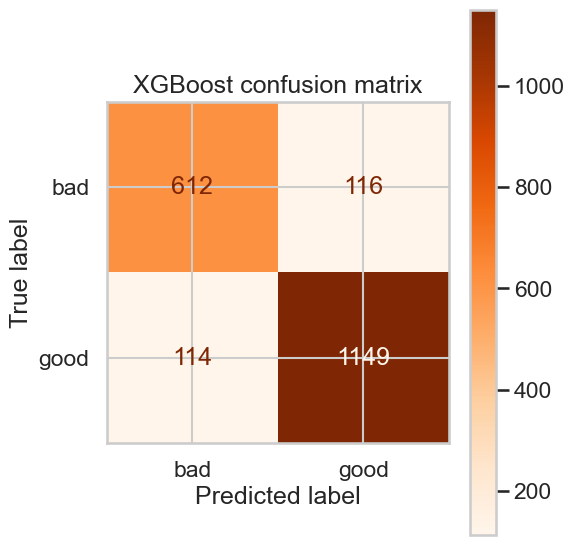

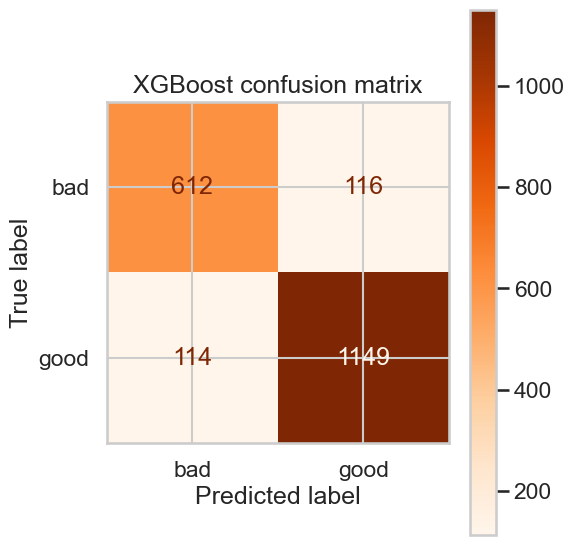

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=label_encoder.classes_,
    cmap="Oranges",
    values_format="d",
    ax=ax,
)
ax.set_title("XGBoost confusion matrix")
fig.tight_layout()
fig


## Feature importance diagnostics

Translate boosted-tree importances into readable n-grams for business-facing discussions.


In [28]:
feature_names = vectorizer.get_feature_names_out()
importance_series = pd.Series(xgb_model.feature_importances_, index=feature_names)
top_importances = importance_series.sort_values(ascending=False).head(20)
top_importances


worst        0.026252
bad          0.022644
best         0.016111
amazing      0.013477
must         0.012374
awesome      0.012175
was not      0.012126
not          0.011982
excellent    0.009888
love         0.009078
loved        0.008870
great        0.008541
delicious    0.007890
no           0.006846
nice         0.006827
pathetic     0.006624
average      0.006243
were good    0.005975
on time      0.005870
thanks       0.005728
dtype: float32

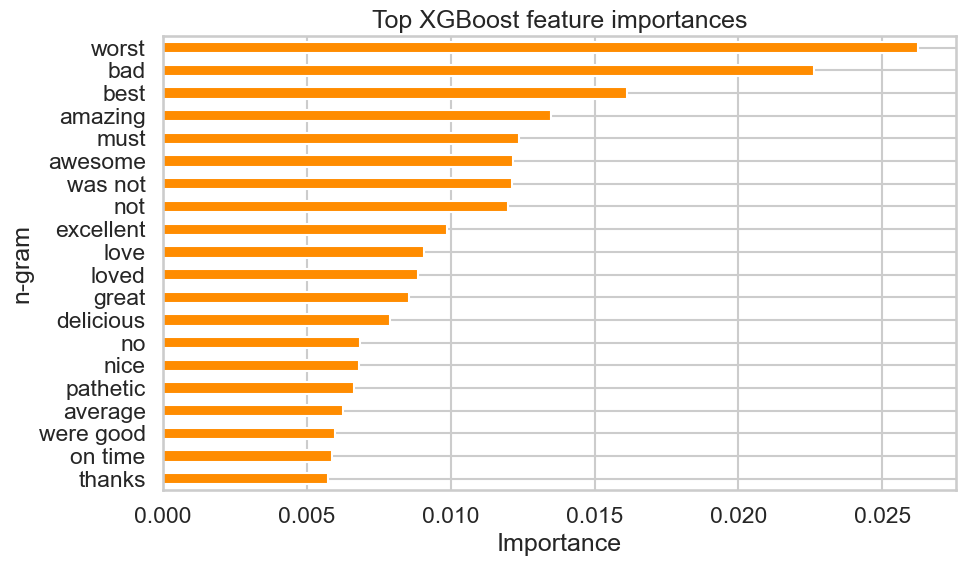

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
top_importances.sort_values().plot.barh(ax=ax, color="darkorange")
ax.set_title("Top XGBoost feature importances")
ax.set_xlabel("Importance")
ax.set_ylabel("n-gram")
fig.tight_layout()
